In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.tree import DecisionTreeRegressor, plot_tree
%matplotlib inline

In [2]:
# Slience SettingWithCopyWarning
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
pseudo_clf = pd.read_csv('result/result_pseudo_clf.csv')
staph_clf = pd.read_csv('result/result_staph_clf.csv')
pseudo_reg = pd.read_csv('result/result_pseudo_reg.csv')
staph_reg = pd.read_csv('result/result_staph_reg.csv')

In [5]:
options = pseudo_clf['file'].str.replace('.npy', '').str.split('_')
feature_names = ['impute', 'condon', 'selection', 'extraction', 'model']
cm = mpl.cm.get_cmap('Greens')

In [6]:
def fms(results, metric, model_map, name):
    data = globals()[results][['file', 'encode', 'model', metric]]

    data['impute'] = False
    data['condon'] = False
    data['selection'] = 0
    data['extraction'] = 0

    data.loc[options.apply(lambda l: l[0]=='i'), 'impute'] = True
    data.loc[options.apply(lambda l: l[1]=='c'), 'condon'] = True
    data.loc[options.apply(lambda l: l[2]=='v'), 'selection'] = 1
    data.loc[options.apply(lambda l: l[2]=='x'), 'selection'] = 2
    data.loc[options.apply(lambda l: l[3]=='p'), 'extraction'] = 1
    data.loc[options.apply(lambda l: l[3]=='t'), 'extraction'] = 2
    data.loc[options.apply(lambda l: l[3]=='s'), 'extraction'] = 3
    data['model'] = data['model'].apply(lambda x: model_map[x])

    dtr = DecisionTreeRegressor(min_samples_split=3, min_samples_leaf=3, max_depth=5)
    dtr.fit(X=data[feature_names], y=data[metric])

    fig, ax = plt.subplots(figsize=(75, 75))
    texts = plot_tree(dtr, feature_names=feature_names,
                      filled=True, rounded=True, node_ids=True, ax=ax)
    model = 'classifiers' if results.endswith('clf') else 'regressors'
    ax.set_title(f'${name}$ {model} decision tree', fontdict={'fontsize': 30})
    
    if results.endswith('clf'):
        data['predict'] = dtr.apply(data.loc[:, feature_names])
        class_score = data.groupby('predict')[metric].mean()
        normalizer = mpl.colors.Normalize(vmin=class_score.min()-0.1, vmax=class_score.max()+0.1)
        for child in ax.get_children():
            if not isinstance(child, mpl.text.Text):
                continue
            for c in class_score.index:
                if child.get_text().split('\n')[0].endswith('#'+str(c)):
                    ax.text(x=child.get_position()[0]+275, y=child.get_position()[1]+100,
                            s='{:.2}'.format(class_score[c]), transform=child.get_transform(),
                            fontdict={'fontsize': 30}, color=cm(normalizer(class_score[c])))
                    break

    fig.savefig(f'graph/{results}.png', bbox_inches='tight')
    plt.close()

In [7]:
metric = 'balanced_accuracy'
model_map = {'logistic': 1, 'rf': 2, 'svm': 3}
fms('pseudo_clf', metric, model_map, 'pseudo')
fms('staph_clf', metric, model_map, 'staph')

In [8]:
metric = 'mean_squared_error'
model_map = {'linear': 1, 'rf': 2, 'svm': 3}
fms('pseudo_reg', metric, model_map, 'pseudo')
fms('staph_reg', metric, model_map, 'staph')

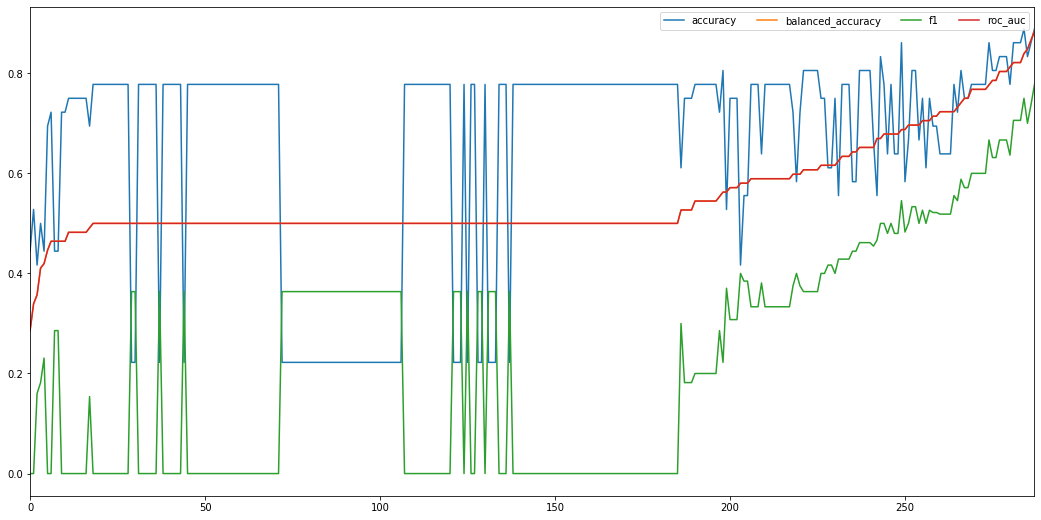

In [55]:
data = pseudo_clf.sort_values('balanced_accuracy').reset_index().drop(columns='index')
fig, ax = plt.subplots(figsize=(18, 9))
data.plot(ax=ax)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=4)

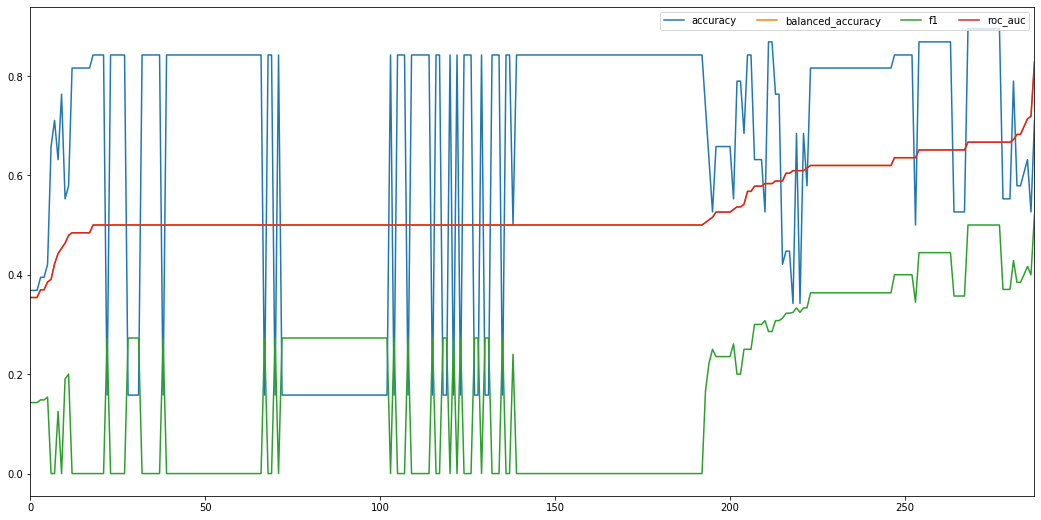

In [54]:
data = staph_clf.sort_values('balanced_accuracy').reset_index().drop(columns='index')
fig, ax = plt.subplots(figsize=(18, 9))
data.plot(ax=ax)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=4)